In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, '../')

In [3]:
from src.utilities.mluar_utils import *

/mnt/swordfish-pool2/milad/conda-envs/huggingface-tlr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pickle as pkl
import pandas as pd
import json

pd.set_option('display.max_colwidth', None)

### Experiment Design

- For each layer, we find pairs of ground-truth texts written by the same author where the corresponding layer's embedding scored them high compared to other layers
- For each layer, we take a sample of these pairs of texts and prompt ChatGPT to find which linguistic level they are similar

#### Step 1:
Generate the embeddings: we did this using the LUAR framework, Now, we load them

In [5]:
# Get positive pairs with with significant scores for layer x
def get_sig_pairs_for_all_layers(preds_path, queries_path, targets_path, threshold=-2):

    embeddings_and_sim = pkl.load(open(preds_path, 'rb'))

    query_authors  = embeddings_and_sim['query_authors']
    target_authors = embeddings_and_sim['target_authors']
    cosine_dist    = embeddings_and_sim['dist_layers']
    
    #load the texts
    query_author_texts_df = pd.read_json(queries_path, lines=True)
    query_author_texts_dict = {x[0]: x[1] for x in zip(query_author_texts_df.author_id.tolist(), query_author_texts_df.syms.tolist())}
    target_author_texts_df = pd.read_json(targets_path, lines=True)
    target_author_texts_dict = {x[0]: x[1] for x in zip(target_author_texts_df.author_id.tolist(), target_author_texts_df.syms.tolist())}
    
    query_authors_texts  = [query_author_texts_dict[a] for a in query_authors]
    target_authors_texts = [target_author_texts_dict[a] for a in target_authors]
    
    distance_matrix = np.concatenate([np.expand_dims(x, 0) for x in cosine_dist])

    same_author_idx = [(i, j) for i, a1 in enumerate(query_authors) for j, a2 in enumerate(target_authors) if a1 == a2]
    distance_zscore_matrix = zscore(distance_matrix, axis=0)
    
    layer_based_sig_pairs = []
    for layer in [0, 1, 2, 3, 4, 5, 6]:
        for i, j in same_author_idx:
            zscore_vec = distance_zscore_matrix[:,i ,j]
            if zscore_vec[layer] > threshold:
                layer_based_sig_pairs.append({
                    'text-1': query_authors_texts[i], 
                    'text-2': target_authors_texts[j], 
                    'z-score': zscore_vec, 
                    'layer-sim': distance_matrix[:, i, j], 'layer': layer
                })

    layer_based_sig_pairs_df = pd.DataFrame(layer_based_sig_pairs)
    return layer_based_sig_pairs_df, len(same_author_idx)

In [16]:
reddit_sig_pairs_df, num_reddit_positive_pairs = get_sig_pairs_for_all_layers('../src/mluar-reddit-preds.pkl', 
                             '/mnt/swordfish-pool2/nikhil/raw_all/test_queries.jsonl',
                             '/mnt/swordfish-pool2/nikhil/raw_all/test_targets.jsonl', threshold=1.5)

In [17]:
reddit_sig_pairs_df.layer.value_counts()

layer
0    454
2     68
3     47
4     10
1      9
5      7
Name: count, dtype: int64

In [18]:
amazon_sig_pairs_df, num_amazon_positive_pairs = get_sig_pairs_for_all_layers('../src/mluar-amazon-preds.pkl', 
                             '/mnt/swordfish-pool2/nikhil/raw_amazon/validation_queries.jsonl',
                             '/mnt/swordfish-pool2/nikhil/raw_amazon/validation_targets.jsonl', threshold=1.5)

In [19]:
num_amazon_positive_pairs

5000

In [20]:
amazon_sig_pairs_df.layer.value_counts()

layer
0    685
2    130
3    104
1     64
4     59
5     32
6     26
Name: count, dtype: int64

In [21]:
pan_sig_pairs_df, num_pan_positive_pairs = get_sig_pairs_for_all_layers('../src/mluar-pan-preds.pkl', 
                             '/mnt/swordfish-pool2/nikhil/pan_paragraph/queries_raw.jsonl',
                             '/mnt/swordfish-pool2/nikhil/pan_paragraph/targets_raw.jsonl', threshold=1.5)

In [22]:
pan_sig_pairs_df.layer.value_counts()

layer
4    134
0    113
3     65
2     62
5     19
1     11
6      9
Name: count, dtype: int64

In [40]:
pan_sig_pairs_df.to_pickle('../data/pan_sig_pairs_df.pkl')
amazon_sig_pairs_df.to_pickle('../data/amazon_sig_pairs_df.pkl')
reddit_sig_pairs_df.to_pickle('../data/reddit_sig_pairs_df.pkl')

In [6]:
# pan_sig_pairs_df    = pd.read_pickle('../data/pan_sig_pairs_df.pkl')
# amazon_sig_pairs_df = pd.read_pickle('../data/amazon_sig_pairs_df.pkl')
# reddit_sig_pairs_df = pd.read_pickle('../data/reddit_sig_pairs_df.pkl')

In [23]:
### Visualize the layer sig
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
reddit_layers, reddit_vals = zip(*reddit_sig_pairs_df.layer.value_counts().to_dict().items())
reddit_vals = [round(x/num_reddit_positive_pairs, 2) for x in reddit_vals]

amazon_layers, amazon_vals = zip(*amazon_sig_pairs_df.layer.value_counts().to_dict().items())
amazon_vals = [round(x/num_amazon_positive_pairs, 2) for x in amazon_vals]

pan_layers, pan_vals = zip(*pan_sig_pairs_df.layer.value_counts().to_dict().items())
pan_vals = [round(x/num_pan_positive_pairs, 2) for x in pan_vals]

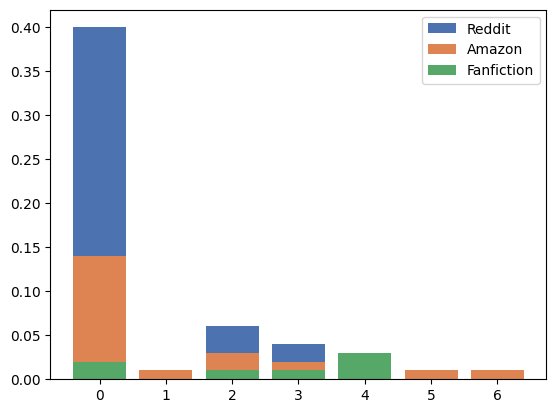

In [35]:
colors = sns.color_palette('deep', 3)
f = plt.figure()
plt.bar(reddit_layers, reddit_vals, label='Reddit', color=colors[0])
plt.bar(amazon_layers, amazon_vals, label='Amazon', color =colors[1])
plt.bar(pan_layers, pan_vals, label='Fanfiction', color= colors[2])
plt.legend()
f.savefig("../data/figures/layer_sig_chart.pdf", bbox_inches='tight')
plt.show()

#### Step 2:

In [46]:
from datadreamer import DataDreamer
from datadreamer.llms import HFTransformers, ParallelLLM, OpenAI
from datadreamer.steps import DataFromPrompt, ProcessWithPrompt,  HFHubDataSource, DataSource, zipped, concat
from functools import partial
from transformers import QuantoConfig
from datasets import concatenate_datasets, load_dataset
import json


model = OpenAI(model_name="gpt-3.5-turbo", api_key='sk-proj-zTbZNk16Ik1pZnqLn38ZT3BlbkFJImq3pd7widkr7RzsC771') #kathy's lab
# model = HFTransformers(
#                 "meta-llama/Meta-Llama-3-8B-Instruct",
#                 quantization_config=QuantoConfig(weights="int8"),
#                 device=0,
#                 device_map="cuda",
#             )
# model.config.pad_token_id = model.config.eos_token_id

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

def evaluate_text_similarities(data_path, document_pairs, linguistic_lvl_name, linguistic_lvl_desc):
    instruction = "Given the two Documents below, rate their <linguistic_lvl> on a scale from 1 to 5: Score 1 equals very low similarity and score 5 equals high similarity. First, give reasons for your score and then output the score. The output should be in the following format: {\"reasons\": \"explain your rating\",  \"score\": \"<json integer>\"}"
    instruction = instruction.replace("<linguistic_lvl>", linguistic_lvl_desc)
    
    with DataDreamer(data_path):
        datasource = DataSource('documents', Dataset.from_list(document_pairs))
        datasource = datasource.map(lambda row: {'inputs': 'Document 1:\n {} \n Document 2:\n {}'.format(row['text-1'], row['text-2'])}, auto_progress=False)
        ds_focus_questions = ProcessWithPrompt(
          "{} describe text similarity".format(linguistic_lvl_name),
          inputs={"inputs": datasource.output["inputs"]},
          args={
             "llm": model,
             "n": 1,
             "instruction": instruction
          },
          outputs={"generations": linguistic_lvl_name},
        ).select_columns([linguistic_lvl_name])
        
        zipped_step = zipped(datasource, ds_focus_questions)

        results_iter = zipped_step.output.dataset
        results_ds   = Dataset.from_generator(partial(gen_from_iterable_dataset, results_iter))

        return results_ds

In [44]:
layer_x_pairs_df = pd.read_json('../data/layer_to_pairs_signficance.json')

In [45]:
layer_x_pairs_df.layer.value_counts()

0    10
1    10
2    10
3    10
4    10
6    10
5     8
Name: layer, dtype: int64

In [47]:
# Given the two Documents below, rate their <linguistic_lvl> on a scale from 1 to 5: Score 1 equals very low similarity and score 5 equals high similarity. First, give reasons for your score and then output the score in the following output format: {\"reasons\": \"explain your rating\",  \"score\": \"<json integer>\"}
ling_phenomena = {
    'syntax': 'syntactic similarity',
    'semantic': 'semantic similarity',
    'lexical': 'lexical similarity',
    'discourse': 'discourse similarity'
}

In [48]:
layer_x_pairs = [row.to_dict() for idx, row in layer_x_pairs_df.iterrows()]

In [49]:
results = []
for key, val in ling_phenomena.items():
    results.append(evaluate_text_similarities('./output', layer_x_pairs, key, val))

[ 🤖 DataDreamer 💤 ] Initialized. 🚀 Dreaming to folder: ./output
[ 🤖 DataDreamer 💤 ] Step 'documents' was previously run and saved, but was outdated. 😞
[ 🤖 DataDreamer 💤 ] Step 'documents' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'documents' finished and is saved to disk. 🎉
[ 🤖 DataDreamer 💤 ] Step 'documents (map)' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'documents (map)' will run lazily. 🥱
[ 🤖 DataDreamer 💤 ] Step 'syntax describe text similarity' was previously run and saved, but was outdated. 😞
[ 🤖 DataDreamer 💤 ] Step 'syntax describe text similarity' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'documents (map)' finished running lazily. 🎉
[ 🤖 DataDreamer 💤 ] Step 'syntax describe text similarity' finished and is saved to disk. 🎉
[ 🤖 DataDreamer 💤 ] Step 'syntax describe text similarity (select_columns)' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'syntax describe text similarity (select_columns)' finished running lazily. 🎉
[ 🤖 DataDreamer 💤 ] Step 'zipped(documents (map), syntax describe text s

In [50]:
all_results = concatenate_datasets(results)

In [51]:
all_results.save_to_disk('../data/described_similarities_ds')

Saving the dataset (0/1 shards):   0%|          | 0/272 [00:00<?, ? examples/s]

### Analyze layer to lingustic similarity:

In [52]:
all_results = load_from_disk('../data/described_similarities_ds')

In [53]:
all_results_df = all_results.to_pandas()

In [54]:
zscores= all_results_df['z-score'].tolist()

In [55]:
all_results_df[['text-1', 'text-2', 'layer', 'lexical', 'syntax', 'discourse', 'semantic']].head(n=50)

,text-1,text-2,layer,lexical,syntax,discourse,semantic
0,"<PERSON>\n\nI love this film. <PERSON>’s greatest achievement is undoubtedly this. I believe <PERSON> performance is the greatest ever put to film.\n—\nTogether, they embody a character that is just fascinating to watch. You never empathise with him, but you do not hate him. It always has stricken me that the <PERSON> is a product of his own environment. NYC is the villain, the enabler. The drugs, the gambling, the scum, the darkness, the violence, all just naturally exists around him and he is just a part of the city’s routine. He cannot break free of its immoral, corruptive nature. He is bound to it.\n—\n<PERSON> contrasts innocence with depravity. The lieutenant drops his kids to school and takes a hit straight after. He wakes up the next day next to a toddler, still wasted from the night before, the drug dealer shown trying to make ends meet for his family and the nun is corrupted. Despite being such a cynical film, I believe <PERSON> tries to shine glimpses of hope on his city.\n—\nThe film doesn’t really stop. It’s scene after scene of some misdeed, mistake or wrongdoing. It literally doesn’t stop gambling, drinking, destroying, or drugging. Neither does the lieutenant. Neither does New York. It’s a fast track to destruction in one way or another. There’s no escape. It never seems like his redemption is possible until the very end but by then it’s too late. The nightclubs, shootings, drugs, stack on top of one another, an evil momentum constantly building, and <PERSON>’s soaring use of music enhances this build up all the more. You feel doomed from the very start.\n—\nFerrara is fascinating in so many ways. This is his peak shit, and one of my all time favourite movies. It genuinely blows me away every time I see it. Underrated.","<PERSON>\n\n“I’m tired of feeling disgusted with myself.”\n\n“Maybe you’re supposed to feel disgusted with yourself when you’re a teenager.”\n\nit’s likeable, but it leaves me wanting more. i think it was too short, and i wish there was more backstory for <PERSON> and <PERSON> (and <PERSON> and <PERSON> as well) to better understand the dynamic there. i’ll probably have to read the book to get that though. also, near the beginning when <PERSON> and <PERSON> were watching desert hearts together and then started making out i was so SHOCKED. where are my people who love desert hearts at.....",0,None,"**Reasons for Rating:**\n\nDocument 1 and Document 2 have different structures, tones, and content. Document 1 discusses a film and analyzes its themes and characters in a detailed and critical manner. On the other hand, Document 2 seems to be a personal reflection or review with a more casual and conversational tone, mentioning specific scenes and expressing personal reactions. The syntactic structures, vocabulary, and overall style of writing in the two documents are quite distinct, with Document 1 being more analytical and descriptive, while Document 2 is more informal and opinionated.\n\n**Score:**\n\n{""reasons"": ""The two documents have different structures, tones, and content, with Document 1 being more analytical and descriptive, and Document 2 being more informal and opinionated. The syntactic structures, vocabulary, and overall style of writing in the two documents are quite distinct."", ""score"": ""1""}",None,None
1,"<PERSON>\n\nI love this film. <PERSON>’s greatest achievement is undoubtedly this. I believe <PERSON> performance is the greatest ever put to film.\n—\nTogether, they embody a character that is just fascinating to watch. You never empathise with him, but you do not hate him. It always has stricken me that the <PERSON> is a product of his own environment. NYC is the villain, the enabler. The drugs, the gambling, the scum, the darkness, the violence, all just naturally exists around him and he is just a part of the city’s routine. He cannot break free of its immoral, corruptive nature. He is bound to it.\n—\n<PERSON> con

In [56]:
all_results_df.layer.value_counts()

0    40
1    40
2    40
3    40
4    40
6    40
5    32
Name: layer, dtype: int64

In [59]:
def aggregate_score(list_of_scores):
    scores = []
    for json_str in list_of_scores:
        if json_str == None:
            continue
        try:
            if "\n\n" in json_str:
                json_str = json_str.split("\n")[-1].strip()

            json_str = json_str.replace("Output:", "").strip()
                
                
            json_obj = json.loads(json_str)            
            scores.append(int(json_obj['score']))
        except:
            print(json_str)
            print('==============')
    return round(np.mean(scores), 2)

# Aggregating layer score
layer_scores_df = all_results_df.groupby('layer').aggregate({
    'lexical': aggregate_score,
    'syntax': aggregate_score,
    'discourse': aggregate_score,
    'semantic': aggregate_score,
}).reset_index()

**Score:** {"reasons": "The content, language, tone, and structure of the two documents are very dissimilar, making their syntactic similarity low.", "score": "1"}
**** {"reasons": "The two documents have very different topics, tones, and contexts, making them semantically dissimilar.", "score": "1"}


In [60]:
layer_scores_df.head(n=7)

,layer,lexical,syntax,discourse,semantic
0,0,1.5,1.60,1.2,1.20
1,1,1.8,2.10,2.1,2.10
2,2,1.6,1.60,1.4,1.70
3,3,1.3,1.22,1.3,1.33
4,4,2.2,2.00,2.1,2.30
5,5,1.5,1.25,1.0,1.12
6,6,1.0,1.10,1.1,1.00
